# Heart Disease Prediction

### *Introduction*
The dataset that our group focuses on is the Coronary Artery Heart Disease data which records 14 attributes of patients in four regions: Cleveland, Hungary, Switzerland, and VA Long Beach. The attributes include age, stage of heart disease, blood pressure, and more.

For our project, we will be focusing on the predictive question,
- Can we predict patients’ stage of heart disease in Cleveland using the predictors age, resting blood pressure, serum cholesterol, and ST depression induced by exercise relative to rest?

We aim to build a classification model that predicts the condition of patients, classifying them in one of the five stages of heart disease (0-4). 0 means that the patients have no heart disease, and the others represent the severity of heart disease in increasing order. We also want to know if our model is accurate in making predictions.


In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
set.seed(3456)
url <- "https://raw.githubusercontent.com/Jessieec/Group-Proposal/main/heart_disease_uci.csv"
heart_data <- read_csv(url)
heart_data

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,63,Male,Cleveland,typical angina,145,233,TRUE,lv hypertrophy,150,FALSE,2.3,downsloping,0,fixed defect,0
2,67,Male,Cleveland,asymptomatic,160,286,FALSE,lv hypertrophy,108,TRUE,1.5,flat,3,normal,2
3,67,Male,Cleveland,asymptomatic,120,229,FALSE,lv hypertrophy,129,TRUE,2.6,flat,2,reversable defect,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
918,55,Male,VA Long Beach,asymptomatic,122,223,TRUE,st-t abnormality,100,FALSE,0,NA,NA,fixed defect,2
919,58,Male,VA Long Beach,asymptomatic,NA,385,TRUE,lv hypertrophy,NA,NA,NA,NA,NA,NA,0
920,62,Male,VA Long Beach,atypical angina,120,254,FALSE,lv hypertrophy,93,TRUE,0,NA,NA,NA,1


### *Preliminary exploratory data analysis*

In [4]:
heart_data_wrangled <- heart_data |>
    select(age, dataset, trestbps, chol, oldpeak, num) |>
    rename(region = dataset, stage = num) |>
    filter(region == "Cleveland")
    
heart_data_wrangled

age,region,trestbps,chol,oldpeak,stage
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
63,Cleveland,145,233,2.3,0
67,Cleveland,160,286,1.5,2
67,Cleveland,120,229,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
57,Cleveland,130,236,0,1
38,Cleveland,138,175,0,0
28,Cleveland,130,132,0,0


In [5]:
#training data
heart_data_split <- initial_split(heart_data_wrangled, prop = 0.75, strata = stage)
heart_data_training <- training(heart_data_split)
heart_data_testing <- testing(heart_data_split)
heart_data_training

age,region,trestbps,chol,oldpeak,stage
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
37,Cleveland,130,250,3.5,0
57,Cleveland,140,192,0.4,0
44,Cleveland,120,263,0.0,0
⋮,⋮,⋮,⋮,⋮,⋮
52,Cleveland,125,212,1,3
58,Cleveland,136,319,0,3
59,Cleveland,164,176,1,3


In [6]:
# mean of selected predictors
heart_data_mean <- summarize(heart_data_training, 
                             age_mean = mean(age),
                             chol_mean = mean(chol), 
                             trestbps_mean = mean(trestbps),
                            oldpeak_mean = mean(oldpeak))|>
                    pivot_longer(cols = age_mean:oldpeak_mean,
                                 names_to = "variables",
                                 values_to = "mean")
heart_data_mean

# number of observations for each class
heart_data_observations <- group_by(heart_data_training, stage) |>
    summarize(count = n())
heart_data_observations

# rows with missing data
heart_data_missing <- filter(heart_data_training, is.na(trestbps) & is.na(chol) & is.na(stage)) |>
    count()
heart_data_missing

variables,mean
<chr>,<dbl>
age_mean,54.5575221
chol_mean,244.8407080
trestbps_mean,132.5973451
oldpeak_mean,0.9783186


stage,count
<dbl>,<int>
0,124
1,42
2,26
3,26
4,8


n
<int>
0


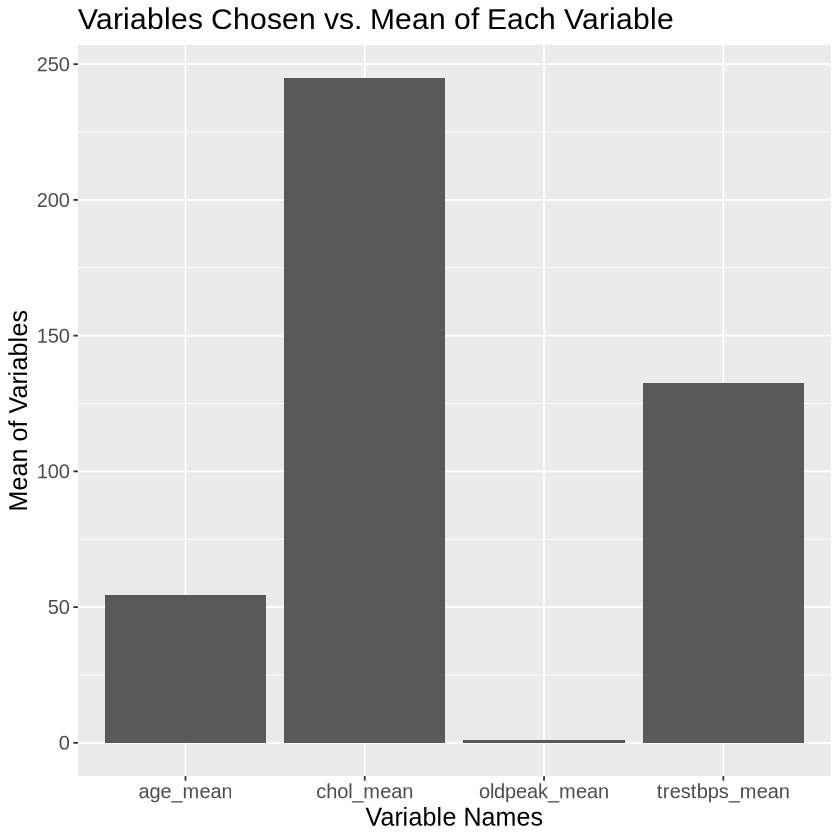

In [7]:
#graph for Mean Data
heart_data_mean_plot <- heart_data_mean |>
    ggplot(aes(x = variables, y = mean)) +
    geom_bar(stat = "identity") +
    labs(x = "Variable Names", y = "Mean of Variables") +
    ggtitle("Variables Chosen vs. Mean of Each Variable") +
    theme(text = element_text(size = 15))
heart_data_mean_plot

#### *Note About Oldpeak on the Mean Bar Chart:*
- Since we will be scaling the data later on in our analysis, the oldpeak value being comparably smaller will not be an issue.

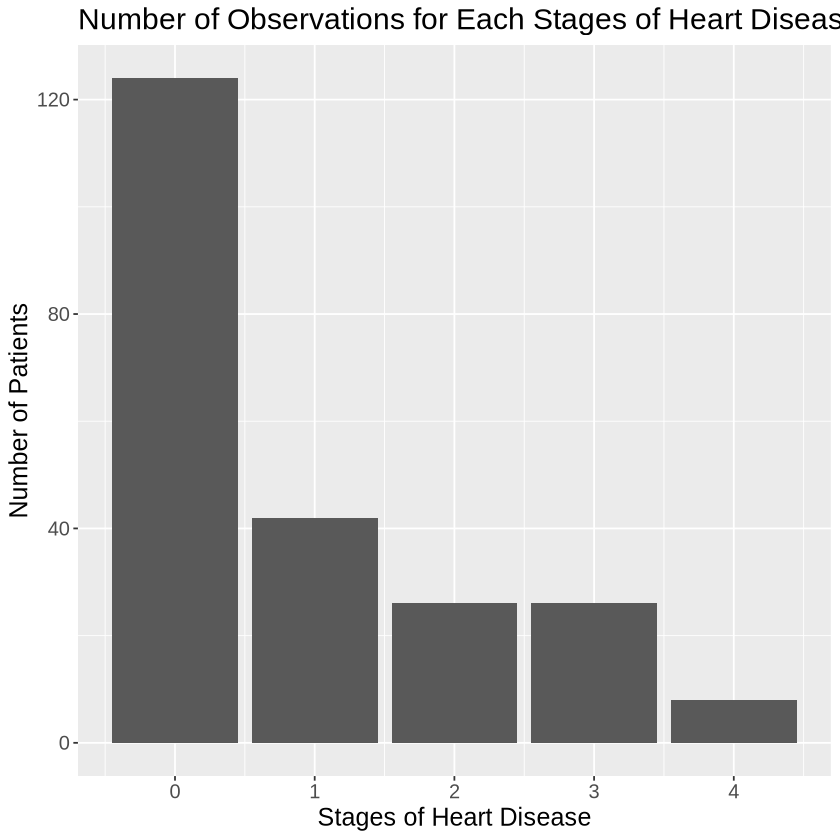

In [8]:
#graph for number of observations
# This section help us visualize the distribution of patients for different stages of heart disease
heart_data_observation_plot <- heart_data_observations |>
    ggplot(aes(x = stage, y = count)) +
    geom_bar(stat = "identity") +
    labs(x = "Stages of Heart Disease", y = "Number of Patients") +
    ggtitle("Number of Observations for Each Stages of Heart Disease") +
    theme(text = element_text(size = 15))
heart_data_observation_plot

### *Method*

- We chose four variables as our predictors: age, resting blood pressure (trestbps), serum cholesterol (chol), and ST depression induced by exercise relative to rest (oldpeak). We removed character and categorical variables because they are difficult to use as predictors in K-NN classification. The “thalach” column is excluded because maximum heart rate happens once. The chosen variables are better indicators because they represent the overall condition of a person.
- We will train our model to use K-NN classification to classify the stage of heart disease from 0 to 4 using our predictors.
- The visualization of scatterplot matrix will help us visualize the training data, with different colors representing disease stages, showing the relation between predictors and the stage of disease.
- Cross-validation will help us determine the best K-value. With the K-value, we can create the K-NN model by setting the mode to “classification” and the engine to “kknn”, and then scale the data using “recipe”. Then, we can use workflow to fit the model to the scaled data.
- The prediction accuracy will be calculated using the training model to classify the data from the testing data and then by dividing the number of correct predictions by the total number of predictions. 
We will optimize the accuracy by testing different training and testing data splits, and then by choosing the model with the highest accuracy.


### *Expected outcomes and significance*

*What do you expect to find?*
- We expect the results to show higher stages of heart disease in the elderly and individuals with higher blood pressure, cholesterol, and ST depression.

*What impact could such findings have?*
- Using models to predict heart disease stages is beneficial for early intervention.
- Sometimes, certain medical tests require a doctor's referral. Our model allows people to easily see for themselves if they are at risk for heart disease.

*What future questions could this lead to?*
- Is our model accurate for the general public (outside of our dataset)?
- How can we improve our model to use categorical and character variables as well to predict heart disease?
- Despite our model’s focus on Coronary Artery Disease, can our model accurately predict heart disease stages for other heart diseases of the general public?
